In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
from simMat import *

plt.rcParams['figure.figsize'] = (12,12)

dataPath = '../Data/'
simMat_yr = np.load(dataPath + 'history_simMat.npy')
min_yr = 1771

fh = open(f'./Genetic1D/bestIndivs_yearly.gen', 'rb') 
Indivs_yr = pickle.load(fh)

# Issues to address here:


- Automatically find groups

- How early do such groups arise?
    - Show evolution of such groups through history (ranking-like)

#### Idea 2:
- Use the optimized scales to reshuffle the matrix, which leads to a diagonal-like matrix.
- Use computer vision techniques to identify squares in the diagonal.

---

In the following, I implement the second idea, as it looks more doable and relies, in principle, on existing software (or mathemathics).

In [2]:
def genToElem(gen):
    """func to convert a gen (list of positions) into sequence of reshuffled elements"""
    order = ['_' for i in range(103)]
    for i,idx in enumerate(gen):
        order[idx] = elemList_AO[i]
    return order

## Exploring the tools in the opencv library.

---

### Image preprocessing:

- Produce reshuffled image using a particular individual out of the 20 obtained for a particular year.
- Convert to int in range 0 - 255
- Upsample: Resize image by factor US_FACT, to increase amount of pixels and detect sharper edges.
- blur: Convolutional average, to remove sharp edges from fluctuations.
- padd: add a frame to the image, so edges are detected on the edges of the image (if any)
- Canny: Canny edge detection algorithm. Detect edges using gradient-based criteria.

### Next, using the edges detected, let's now detect contours (closed figures in the image)

Function cv2.findContours takes 3 inputs:

1. Grayscale image
2. Retrieval mode:
    - cv2.RETR_LIST → Retrieve all contours
    - cv2.RETR_EXTERNAL → Retrieves external or outer contours only
    - cv2.RETR_COMP → Retrieves all in a 2-level hierarchy
    - cv2.RETR_TREE → Retrieves all in the full hierarchy

    Hierarchy is stored in the following format [next, previous, First child, parent].
<br>

3. Approximation mode:

    - cv2.CHAIN_APPROX_NONE: stores all the boundary points. 
    - cv2.CHAIN_APPROX_SIMPLE: only provides these start and endpoints of bounding contours
    
    
Returns 3 outputs:

1. Grayscale image
2. Contours
3. Hierarchy

---

### Problem to address: Not all elements are being assigned to a group.  [SOLVED]

For some elements, similarities with similar elements are not particularly strong, so are not detected by CV algo.

Idea is, within the CV algo, create a new group with all the elements lying in the middle of two non-touching, contiguous squares. This replaces CV criteria by a "closeness" criterium, which comes down to the optimization performed with genetic algo, and ultimately to similarity.

In [3]:
def getGroups_CV(yr,ind,show=False,th=10,b=1,blur_sz=7,ups=5,max_grp=20):
    """Use computer vision algorithms to find blocks of 
    similar elements in the diagonal of similarity matrix"""
    # Obtain simetrized and reshuffled matrix using year=yr and ind-th ordering
    P = plot_simMat_yr(simMat_yr,yr,min_yr=min_yr,raw=False,scale=15,ordering=Indivs_yr[yr][ind],show=False)

    # Set diagonal elements equal to avg of sorroundings, so edge is clearer
    idx = np.diag_indices(P.shape[0]-1)
    P[idx] = (P[idx[0],idx[1]+1] + P[idx[0],idx[1]-1])/2

    ## Start processing image
    
    # Convert matrix values into integers btwn 0-255
    img = np.rint(((P/np.max(P))*255)).astype(np.uint8)
    
    # Upsample: Increase num. pixels by duplicating each pixel locally
    US_FACT = ups # Upsample factor
    upsamp = cv2.resize(img,dsize=(img.shape[0]*US_FACT,img.shape[1]*US_FACT),
                        interpolation=cv2.INTER_NEAREST)  
    
    # Blur operation. Avg to fade some spurious edges
    blur = cv2.medianBlur(upsamp, blur_sz)
    
    # Add padding, so the image is framed and groups to the edges can be detected
    padd = cv2.copyMakeBorder(blur, 1,1,1,1, cv2.BORDER_CONSTANT, None, 0)

    # Detect edges with Canny algorithm
    canny = cv2.Canny(padd, th , th + b)
    
    # Find rectangles
    cnts = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[1]

    cp=upsamp.copy()
    final_cnts = []
    for c in cnts:  # Loop through found contours
        x,y,w,h = cv2.boundingRect(c)
        # Conditions: Square on the diagonal, below certain size, above certain size
        if x==y and w < max_grp*US_FACT and w > US_FACT:
            final_cnts.append(c)
            if show:  # Draw rectangles on image
                cv2.rectangle(cp, (x//US_FACT *US_FACT, y//US_FACT *US_FACT),
                              ((x + w)//US_FACT *US_FACT, (y + h)//US_FACT *US_FACT), (255,0,0), 1)

    if show:
        cmap = sns.color_palette("magma_r", as_cmap=True)
 
        fig,ax = plt.subplots(1,3,figsize=(15,9))
        ax[0].imshow(blur,cmap=cmap)
        ax[0].set_title('Blurred')
        
        ax[1].imshow(canny,cmap=cmap)
        ax[1].set_title('Canny edge detection')
        
        ax[2].imshow(cp,cmap=cmap)
        ax[2].set_title('Original with found blocks')
        
        for i in range(3):
            ax[i].axis('off')
        plt.tight_layout()
        plt.show()
        
        
    # Now let's extract the actual groups from the squares
    seq = genToElem(Indivs_yr[yr][ind])
    grps = {} # Do as a dict so repeated entries are not added
    
    covered = np.ones(P.shape[0])  # Array to store which positions have been covered
    for c in final_cnts:  # Loop through found rectangles
        x,y,w,h = cv2.boundingRect(c)
        st = seq[x//US_FACT:x//US_FACT+w//US_FACT]  # Add mins and maxs to include border of square too
        
        covered[x//US_FACT:x//US_FACT+w//US_FACT] = 0  # These positions are covered already
        # Add group only if it contains more than one element
        if len(set(st))>1:  
            grps[str(set(st))] = set(st)
            
    # Now form groups of consecutive elements that aren't covered by any square
    p = np.array(seq[:P.shape[0]])[covered.astype(bool)]
    
    c,count=0,False
    lens=[]
    for d in np.diff(covered):
        if d==1:      c+=1; count=True
        if d==0 and count:  c+=1
        if d==-1: lens.append(c); c=0; count=False
            
    cum=0
    for l in lens:
        if l>1:
            st=p[cum:cum+l]
            grps[str(set(st))] = set(st)
        cum+=l
    
    return list(grps.values())

yr=1868
ind=19

grupos = []
#for th in [1,10,50]:
gs = getGroups_CV(yr,ind,show=True,th=th,b=10,blur_sz=13,ups=10)
#    grupos.append(gs)

NameError: name 'th' is not defined

## Results of using these algorithms depend on a few parameters:

        
<font color="red">
    
- Upsampling factor
- Blurring window size
- From Canny algorithm
    - Hard threshold (th)
    - Threshold width (b)

<font color="black">
    
These can be manually tuned for an image in particular, but that misses the whole point.

#### Now we should design an algorithm that considers a range of results coming from several sets of parameters. 

Naturally, as `hard threshold` decreases, more edges are detected. As observed above, this increases the amount of "groups" found, but also introduces more spurious results from noise in the matrices. Our algorithm could start from this more sensitive picture, and iteratively discard groups using information from higher thresholds.

We should as well have some way to deal with nestings. However this is an issue that may dissapear once results from all 20 PTRs for a year have been considered, which is supposed to reduce noise leaving only the most important features, and thus groups.

<font color='green'>
<br>

Additionally we need an algorithm that can generalize to different years, which is important as different years have different amount of elements (thus size of matrix).

<font color="blue">
    
# Ideas:

- Work with an imperfect algorithm, while postprocessing of all the packs of groups will make sure results capture the common things there.
- Give more relevance to orderings with a better fitness score?


- For each year, for each ordering:
    - Produce a range of possible packs of groups, each one with different parameters (th, b, blur, upsamp). 
    - Assign relative importances to each of these packs depending on the parameters?
    - Two options:
        - Average out these to return a clean pack of groups representing the given individual.
        - Return a single pack containing all groups found. Averaging is then done with all groups found.
        
<font color="red">
    
### In any case, every idea leads to the averaging out of groups.

---

# Averaging out.

Or in prettier terms, statistical noise reduction.

### Idea: First, for each group `g0` in a pack, select the most similar group in the other packs
#### How to define similarity?

Consider intersection and length of groups.

If comparing `g0` with some other group `g1`, could use:

$$M_1 = \frac{|g0 \cap g1|}{|g0|} $$

or


$$M_2 = \frac{|g0 \cap g1|}{\sqrt{|g0|*|g1|}} $$

or

Semejanza Tanimoto
$$M_3 = \frac{|g0 \cap g1|}{|g0\cup g1|} $$

$M_1$ only takes into account length of intersection and length of `g0`, while $M_2$ takes into account length of `g1` as well.

$M_2$ looks better as it helps discard groups too disimilar in size.

Example: 


g0 = {'Rh', 'Mn', 'La', 'Fe'}

Most similar groups in pack2:

    M1     M2      Group

    1.000  1.000   A={'Rh', 'Mn', 'La', 'Fe'}
   
    0.750  0.750   B={'Rh', 'Mn', 'Fe', 'Cd'}
    
    1.000  0.516   C={'Rh', 'Co', 'Ni', 'Mg', 'Mn', 'La', 'Cd', 'Zn', 'Sr', 'Ca', 'Ba', 'Cu', 'Pb', 'Pd', 'Fe'}
    
For $M_1$, C is to `g0` as similar as A, as C is larger (thus higher prob. of finding any element). But for $M_2$, they're quite disimilar, discarding C. Let's stick to $M_2$.

#### Next:

Now, for each group candidate, we have a set of similar groups. Next step is to produce a single group out of such collection of groups, which in the end will count as the smoothening or averaging out we were looking for.

For that, a voting mechanism will be used: If an element is in at least 50% of the groups in the set, then such element will make it to the new smoothened group.

Example:

    Compare to {'Sr', 'Ba'}

    In pack 0: M2 = 1.000                   {'Sr', 'Ba'}

    In pack 1: M2 = 1.000                   {'Sr', 'Ba'}

    In pack 2: M2 = 0.707       {'Sr', 'Ca', 'Mg', 'Ba'}

    In pack 3: M2 = 0.707       {'Sr', 'Ca', 'Mg', 'Ba'}

    In pack 4: M2 = 0.707       {'Sr', 'Ca', 'Mg', 'Ba'}

    In pack 5: M2 = 0.632 {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}

    In pack 6: M2 = 0.632 {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}

    In pack 7: M2 = 0.632 {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}

The resulting group will then be: `{'Sr', 'Ca', 'Ba'}`.

The average $M_2$ can be reported as a measure of the degree of general agreement. 

In [4]:
def avg1(grps):
    """Average out a list of groups. 
    Given a list of sets, return a unique set containing the elements 
    present in at least 50% of the input sets"""
    
    # Join them, then count number of times each element appears
    join = []
    for l in grps:        join += list(l)
    
    # Get list of uniq elems, then count number of appearances of each
    uniq = set(join)
    accept = len(grps)//2  # Acceptance threshold

    final_grp = []
    for e in uniq:
        if join.count(e) >= accept:  # If num appear > threshold, add to group
            final_grp.append(e)
            
    return set(final_grp)

# Example
grps_ex =  [{'Sr', 'Ba'}, 
            {'Sr', 'Ba'},
            {'Sr', 'Ca', 'Mg', 'Ba'},
            {'Sr', 'Ca', 'Ba', 'Pb', 'Pd'}]

avg1(grps_ex)

{'Ba', 'Ca', 'Sr'}

### In general, the algorithm for "smoothening" groups looks like this:


<img src="../inf/set_smooth_algo.png" width="700">

<font color="red">
    
This is performed on each individual on a given year, and each $P_g$ corresponds to a unique set of CV parameters, returning a set of groups for every individual.

The 20 sets of groups (one for each individual) are then passed through a similar algorithm to return a final list of groups, corresponding to that particular year.

In [5]:
# As an example, let's generate an Initial state starting from individual #9 from year 2016
yr,ind=1970,9

# Generate 81 different packs of groups, using different combinations of parameters
InitState = []
for upsamp in [3,9,13]:
    for th in [1,10,50]:
        #for b in [1,10,20]:
        b=1
            #for blur_w in [7,9,11]:
        blur_w = 11
        gs = getGroups_CV(yr,ind,show=False,th=th,b=b,blur_sz=blur_w,ups=upsamp)
        InitState.append(gs)

In [6]:
def M2(A1,A2):         
    A1,A2 = set(A1),set(A2)
    return len(A1.intersection(A2))/np.sqrt(len(A1)*len(A2))

def M3(A1,A2):         
    A1,A2 = set(A1),set(A2)
    return len(A1.intersection(A2))/len(A1.union(A2))

def mainIter(InitState, NIters=1,sem=M2):
    """Implement the main iteration of algorithm. 
    Produce agreement sets among various CV parameters."""    
    CurrState = InitState.copy()
    
    for Iter in range(NIters):
        mean_m2 = 0 # Keep track of mean similarity
        FinalState = []
            
        for g,Pg in enumerate(CurrState):  # For each pack in InitState
            Pg_smooth = {}          # Dict to store the updated version of InitState (dict so no repeats)
            for Ai in Pg:                  # For each group in pack Pg
                sim_grps = []  # Store most similar groups to Ai
                sim_grps_score = [] # Store similarity score (M2)

                # Loop over all packs, excluding Pg
                for i,pck in enumerate(CurrState): 
                    if i!=g:
                        # Best match found in this pack
                        most_sim,best_m2 = None,0

                        for Aj in pck: # Then for every group in such pack 
                            #Compare how similar Ai is to Aj
                            if len(Ai)==0 or len(Aj)==0: print(Ai,Aj)
                            m2 = sem(Ai,Aj)
                            if m2>best_m2: most_sim = set(Aj); best_m2 = m2

                        if most_sim:  # If not None
                            sim_grps.append(most_sim)
                            sim_grps_score.append(best_m2)

                Avgd_Ai = avg1(sim_grps)
                if len(Avgd_Ai)>1:      Pg_smooth[str(sorted(Avgd_Ai))] = Avgd_Ai
                
            # Before appending to FinalState, clean repeated sets 
            FinalState.append(list(Pg_smooth.values()))  # Add smoothened Pg to Final state
            mean_m2 += np.mean(sim_grps_score)
            
        CurrState = FinalState.copy()  # Set current state to the newly formed state
        if Iter > 1:
            if mean_m2/len(FinalState) == meanM2: break
        meanM2 = mean_m2/len(FinalState)
        print(f"mean M2 = {meanM2:.3f} after {Iter+1} iters.")
        
        
        
    def getUnique(FState):
        """Input: list of lists of sets  [ [{},{},...], [{},{},...], ...]
        Return a single list containing all unique sets"""
        Out = []
        for l in FState: Out += l # Concatenate all resulting groups
        # Filter for only unique
        Out_d = {}
        for l in Out:
            Out_d[str(sorted(l))] = l
        return list(Out_d.values())
        
    Return = getUnique(FinalState)
    TotalUniqInitState = getUnique(InitState)

    print(f"Loop finished after {Iter+1} iterations.")
    print(f"\t ** InitState contained {len(TotalUniqInitState)} unique groups.")
    print(f"\t ** FinalState contains {len(Return)}\n")
    return Return

In [10]:
s = mainIter(InitState, NIters=5,sem=M2)

mean M2 = 0.709 after 1 iters.
mean M2 = 0.931 after 2 iters.
mean M2 = 0.948 after 3 iters.
Loop finished after 4 iterations.
	 ** InitState contained 139 unique groups.
	 ** FinalState contains 44



### Our algorithm is now mounted. Finally, let's do the same but with the results obtained from each individual for a given year, to get a final result for that year.

In [11]:
def smoothForYear(yr):
    """Run two instances of smoothing algorithm:
        1. For a range of parameters, run algo. to obtain list of groups attached to individual i
        2. Run algo. over all 20 lists of groups, one per individual.
        
    TO-DO: Find good combinations of parameters, so results are reproducible + CV is reliable"""
    
    InitState_year = []
    for ind in range(20):
        # Generate 3² different packs of groups, using different combinations of parameters
        InitState = []
        for upsamp in [3,9,13]:
            for th in [1,10,50]:
                gs = getGroups_CV(yr,ind,show=False,th=th,b=b,blur_sz=blur_w,ups=upsamp)

                ### Check len of sets
                for i in gs:
                    if len(i)<2: print(i)

                InitState.append(gs)

        # Now apply algorithm to smoothen sets
        print(f"Smoothening ind = {ind}...")
        s_ind = mainIter(InitState, NIters=10)
        InitState_year.append(s_ind)

    print("Now processing results from all individuals")
    return mainIter(InitState_year, NIters=10)

#f = smoothForYear(yr)
#f

## With the algorithms all mounted, we need to find good sets of CV parameters to use, so that results are much more robust.

Good parameters will probably be different from year to year as size of matrices as well as pixel intensity vary. Test this and if necessary find different sets of parameters for different periods.

---

First off: Explore interplay between `blur_sz` and `ups` as these two are closely related and both correspond to preprocessing before edge detection, so they control the `Blurred` image.

Apparently, the higher the upsampling `ups`, the better the results, but also we get a larger image so algorithm is much slower. Appropriate values for `blur_sz` should be higher, but relatively close to `ups`. Let's adopt as a rule 0 $\leq$ `blur_sz` - `ups` $\leq$ 10, with `ups` $\geq$ 15. This shows an acceptable performance over the whole range of years, so we'll stick to it.

Now, explore `th` and `b`. To be clear: `th` + `b` is a hard threshold for the value of the gradient of the image, meaning that if gradient G $\geq$ `th` + `b`, it is automatically detected as an edge.

If `th` $\leq$ G $\leq$ `b`, then decision is made based on connectivity pattern.


Let's try and switch parameters, so we deal only with hard threshold and lower threshold, so that ht = th + b, and lt = th, then b = ht-th.

With this we can test if in our case we actually require two parameters, or can leave it down to just the hard threshold.

---

Influence of lower threshold seems to be minimal up to some point. e.g. if `ht` = 50, influence of `lt` is minimal for values of `lt` $\leq$ 40, but becomes important as `lt` approaches `ht`. Take away is that `lt` can be anything not too close to `ht`, leaving space for the soft criterium of Canny's algo. We could stick to the rule `ht` - `lt` $\geq$ 10, which in practice reduces these two parameters to only one, `ht`.

- With `ht` low (< 50), influence of `lt` is negligible, for higher values of `ht`, `lt` becomes more important as most of the rejected edge candidates are sent for a second revision under the soft criterium.
To avoid all this, we could just set low values of `ht`, say below 40.

- It looks promising to use low values of `lt`, as it contributes with more "wild" groups, as the criterium becomes easier to pass.

#### High values of lt detect very strong squares only, while lower values allow to detect more subtle groups.

#### Summary on lt and ht:
- `ht` should be set to values below, or can even be set to 40.
- `lt` can be anything between 0 and `ht`, every different value contributes with different and interesting findings.

## Summary

- `ups` $\geq$ 15
- 0 $\leq$ `blur_sz` - `ups` $\leq$ 10
- `ht` ~ 40
- 0 $\leq$ `lt` $\leq$ `ht`

In [8]:
def smoothForYear(yr):
    """Run two instances of smoothing algorithm:
        1. For a range of parameters, run algo. to obtain list of groups attached to individual i
        2. Run algo. over all 20 lists of groups, one per individual.
        
    TO-DO: Find good combinations of parameters, so results are reproducible + CV is reliable"""
    
    InitState_year = []
    for ind in range(20):
        # Generate different packs of groups, using different combinations of parameters
        InitState = []

        ups = 15
        ht = 40
        
        N_lt = 10
        # Make low values of lt (exponentially) more likely
        prob = np.exp(-np.arange(0,ht)/20)
        prob = prob/np.sum(prob) 
        for blur_sz_add in range(2,10,2): # let blur_sz = ups + 2, 4, 6, ... 
            for lt in np.random.choice(np.arange(0,ht),size=N_lt,p=prob):
                # ^^ A random sample of values, between 0 and ht-1 
                blur_sz = ups + blur_sz_add
                
                b = ht-lt
                th = lt
                
                gs = getGroups_CV(yr,ind,show=False,th=th,b=b,blur_sz=blur_sz,ups=ups)

                ### Check len of sets
                for i in gs:
                    if len(i)<2: print(i)

                InitState.append(gs)

        # Now apply algorithm to smoothen sets
        print(f"Smoothening ind = {ind}...")
        s_ind = mainIter(InitState, NIters=10)
        InitState_year.append(s_ind)

    print("Now processing results from all individuals")
    return mainIter(InitState_year, NIters=10)

yr = 2016
f = smoothForYear(yr)
f

Smoothening ind = 0...
mean M2 = 0.988 after 1 iters.
mean M2 = 1.000 after 2 iters.
Loop finished after 3 iterations.
	 ** InitState contained 111 unique groups.
	 ** FinalState contains 47

Smoothening ind = 1...
mean M2 = 0.651 after 1 iters.
mean M2 = 0.829 after 2 iters.
mean M2 = 0.972 after 3 iters.
Loop finished after 4 iterations.
	 ** InitState contained 113 unique groups.
	 ** FinalState contains 35

Smoothening ind = 2...
mean M2 = 0.930 after 1 iters.
mean M2 = 1.000 after 2 iters.
Loop finished after 3 iterations.
	 ** InitState contained 105 unique groups.
	 ** FinalState contains 47

Smoothening ind = 3...
mean M2 = 0.729 after 1 iters.
mean M2 = 0.995 after 2 iters.
Loop finished after 3 iterations.
	 ** InitState contained 116 unique groups.
	 ** FinalState contains 53

Smoothening ind = 4...
mean M2 = 0.897 after 1 iters.
mean M2 = 1.000 after 2 iters.
Loop finished after 3 iterations.
	 ** InitState contained 118 unique groups.
	 ** FinalState contains 56

Smootheni

KeyboardInterrupt: 

## TO-DO

Find a way of graphically showing evolution of groups just found. What we'll do once all algos are set-up, will be doing a run for each year, which will leave us with a set of groups for every year. 

We need to show how the groups evolve.

IDEA: 
- Starting from year X, compare the groups to next year's (X+2) groups using $M_2$, that is, for each group found in year X, find the most similar group in year X+2, and store the $M_2$ value.

- Do the same in retrospective, that is, swap years X and X+2 and repeat the above. If a group found in X+2 is new in that year, then it will have a low $M_2$ value when compared to any group found in X. Set an empirically defined threshold for that.

In [23]:
## Load all groups generated with script

grps={}
for yr in range(1800,2018,2):
    try:
        fh = open(f'foundGroups/grp{yr}.bin','rb')
        grps[yr] = pickle.load(fh)[1]
    except:
        print(f"{yr} not found")
        
grps[1864] = grps[1862] # Just copy results from previous year as there was an error  

grps

1864 not found


{1800: [{'Cl', 'O'},
  {'C', 'Cu', 'O', 'Pt', 'S', 'Sn'},
  {'Cu', 'H', 'N', 'Na', 'Pt'}],
 1802: [{'Ag', 'H', 'K', 'Na'},
  {'Ba', 'Ca', 'Co', 'Cu'},
  {'Ba', 'Ca', 'Co', 'Sn'},
  {'Al', 'As', 'C', 'P', 'S'},
  {'Cl', 'N', 'O'},
  {'Al', 'As', 'C', 'P', 'Pt', 'S'}],
 1804: [{'H', 'K', 'Na'},
  {'Ag', 'H', 'K', 'Na'},
  {'Ir', 'U'},
  {'Ag', 'C', 'Co', 'Cu', 'Fe', 'H', 'Hg', 'K', 'Na', 'Pt', 'Rh', 'Zn'},
  {'Ba', 'Ca', 'Co', 'Pb'},
  {'Ag', 'C', 'Ca', 'Co', 'Cu', 'Fe', 'H', 'Hg', 'K', 'Na', 'Pt', 'Rh', 'Zn'},
  {'Al', 'As', 'P'},
  {'Cl', 'N', 'O', 'S'},
  {'Ba', 'Ca', 'Pb'}],
 1806: [{'Cl', 'I', 'N', 'O'},
  {'Ba', 'Pb', 'Pd'},
  {'Ag', 'Hg', 'K', 'Na'},
  {'Ba', 'Ca', 'Co', 'Pb', 'Pd'},
  {'Ir', 'Sn', 'Ti', 'U'},
  {'Al', 'As', 'Fe', 'P'},
  {'Al', 'As', 'P'},
  {'Cl', 'H', 'I', 'K', 'N', 'O'},
  {'Ag', 'Au', 'C', 'Ni', 'Pt', 'Rh', 'Zn'},
  {'Ag', 'Au', 'C', 'Hg', 'K', 'Na', 'Ni', 'Pt', 'Rh', 'Zn'},
  {'Cl', 'H', 'I', 'N', 'O'},
  {'Cl', 'H', 'I', 'K', 'N', 'Na', 'O'}],
 1808: [{'Al'

### Let's find the origin of groups!

Compare group in yr X against all groups found within 6 years in the past (3 last bags of groups).

In [24]:
def getMostSimTo(g, bag):
    """Return group in `bag` that is most similar to group `g`, alongside similarity."""
    
    bestM2,bestG = 0,None
    for g1 in bag:
        score = M2(g,g1)
        if score>=bestM2:
            bestM2=score; bestG=g1
    return bestG,bestM2       
    

## First: Find new groups
# Defined as groups which share no significant similarity to any group in the year before.

threshNew = 0.7
newGrps = []

for yr in range(1802,2016,2):
    if yr==1802:    grps_yr6bf = grps[1800]
    elif yr==1804:  grps_yr6bf = grps[1800] + grps[1802]
    else:           grps_yr6bf = grps[yr-2]+grps[yr-4]+grps[yr-6]   # All groups found within 6 yrs in the past
    
    grps_yrCur = grps[yr] # Next year
    
    # For every group in yr X, find most similar group in yr X-2,X-4,X-6 
    for g in grps_yrCur:
        G,sim = getMostSimTo(g, grps_yr6bf)
    
        if sim <= threshNew:
            newGrps.append((g,yr))  # If new group g is found, append g and `year of discovery`
            
newGrps

[({'Ag', 'H', 'K', 'Na'}, 1802),
 ({'Ba', 'Ca', 'Co', 'Cu'}, 1802),
 ({'Ba', 'Ca', 'Co', 'Sn'}, 1802),
 ({'Al', 'As', 'C', 'P', 'S'}, 1802),
 ({'Al', 'As', 'C', 'P', 'Pt', 'S'}, 1802),
 ({'Ir', 'U'}, 1804),
 ({'Ag', 'C', 'Co', 'Cu', 'Fe', 'H', 'Hg', 'K', 'Na', 'Pt', 'Rh', 'Zn'}, 1804),
 ({'Ag', 'C', 'Ca', 'Co', 'Cu', 'Fe', 'H', 'Hg', 'K', 'Na', 'Pt', 'Rh', 'Zn'},
  1804),
 ({'Ba', 'Ca', 'Pb'}, 1804),
 ({'Ba', 'Pb', 'Pd'}, 1806),
 ({'Ag', 'Au', 'C', 'Ni', 'Pt', 'Rh', 'Zn'}, 1806),
 ({'Cl', 'H', 'I', 'K', 'N', 'Na', 'O'}, 1806),
 ({'Be', 'Sn'}, 1808),
 ({'Cl', 'F', 'I'}, 1810),
 ({'Cr', 'O', 'S', 'Te'}, 1810),
 ({'C', 'Mg', 'N'}, 1810),
 ({'Bi', 'Mg'}, 1812),
 ({'Co', 'Hg', 'Ni', 'Pd'}, 1814),
 ({'Ti', 'U', 'Zr'}, 1814),
 ({'B', 'F'}, 1814),
 ({'Co', 'Fe', 'Hg', 'Ni', 'Pd'}, 1814),
 ({'Ba', 'Ca', 'Sr', 'Zn'}, 1816),
 ({'Te', 'W'}, 1816),
 ({'Ni', 'Pd', 'Pt'}, 1818),
 ({'C', 'S', 'Se'}, 1818),
 ({'Bi', 'Rh'}, 1818),
 ({'Ce', 'Li', 'Os'}, 1818),
 ({'Be', 'Mn'}, 1820),
 ({'Bi', 'Os'}, 1822)

## Create a kind of circular, divergent chord diagram.

Concentric circles represent years, with inner circles being earlier years.

Groups are shown as they appear. Each group in year X is connected to every group in year X+2, intensity of connection is given by similarity between said pair of groups.

## Let's start simple, by just using a flat version, with years being represented by lines, lowest year at the bottom.

### Algorithm:

Compute relations for every pair of groups yearly (X -> X+2, then X+2 -> X+4, etc).

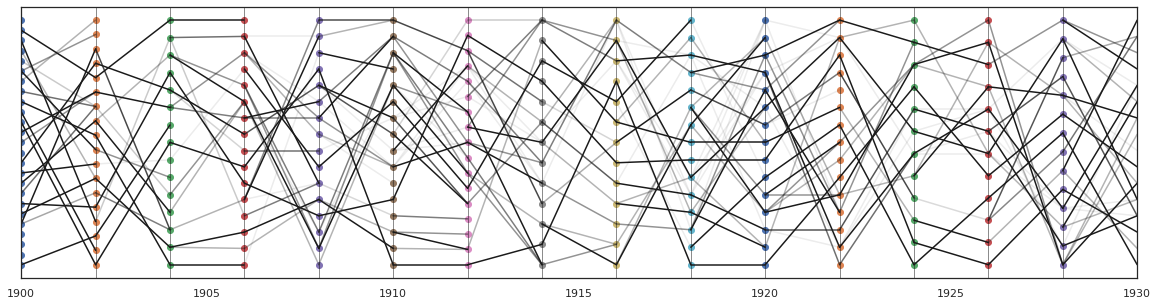

In [169]:
grps2 = grps.copy()

# Let's test idea using first 10 years
fig,ax = plt.subplots(figsize=(20,5))
THRESH = 0.8
MIN_YR = 1900
MAX_YR = 1930

ax.set_xlim(MIN_YR,MAX_YR)
ax.set_ylim(0,1)
ax.axes.get_yaxis().set_visible(False)

def connectMatrix(b1,b2):
    """Return connectivity matrix between bags b1 and b2"""
    m=np.zeros((len(b1),len(b2)))
    for i,g1 in enumerate(b1):
        for j,g2 in enumerate(b2):
            m[i,j] = M2(g1,g2)
    return m




for yr in range(MIN_YR,MAX_YR,2):
    # A line for each year
    ax.axvline(yr,color='k',linewidth=0.5)  
    
    
    grpCurr = grps2[yr]
    grpNext = grps2[yr+2]
    
    # Calculate conexion matrix
    CM = connectMatrix(grpCurr,grpNext) # Get all coefficients
    
    # Rescale to [0,1] by using transform (x-THRESH)/(1-THRESH)
    # Then mask coefficients to remove all below THRESH
    CM = (CM-THRESH)/(1-THRESH)*(CM>THRESH) 
    
    # If all in a col are zero, don't plot that point
    notkeep=CM.sum(axis=0)==0
    CM=np.delete(CM,notkeep,axis=1)
    
    # Now update group next year
    newGrpNext = []
    for i,g in enumerate(grps2[yr+2]):
        if not notkeep[i]: newGrpNext.append(g)
            
    grps2[yr+2] = newGrpNext

    
    # Add groups for this year, represented as a point
    if len(grps2[yr])>1:    dots = np.linspace(0.05,0.95,len(grps2[yr]))
    else:                   dots = [0.5]
    yr_dots = np.repeat(yr,len(grps2[yr]))
    ax.scatter(yr_dots,dots)
    
    # Now include links between points
    # grps[yr] is a list -> thus has a particular order. 
    if len(grps2[yr+2])>1:    dots_Next = np.linspace(0.05,0.95,len(grps2[yr+2]))
    else:                     dots_Next = [0.5]

    # Now draw connections
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            ax.plot([yr,yr+2],[dots[i],dots_Next[j]],alpha=CM[i,j],color='k')        
    
plt.show()

In [160]:
grps2

{1800: [{'Cl', 'O'},
  {'C', 'Cu', 'O', 'Pt', 'S', 'Sn'},
  {'Cu', 'H', 'N', 'Na', 'Pt'}],
 1802: [{'Cl', 'N', 'O'}],
 1804: [{'Cl', 'N', 'O', 'S'}],
 1806: [{'Cl', 'I', 'N', 'O'},
  {'Cl', 'H', 'I', 'K', 'N', 'O'},
  {'Cl', 'H', 'I', 'N', 'O'},
  {'Cl', 'H', 'I', 'K', 'N', 'Na', 'O'}],
 1808: [{'Ag', 'H', 'K', 'Na'},
  {'H', 'K', 'Na'},
  {'Cl', 'I', 'N', 'O', 'S'},
  {'C', 'Cl', 'I', 'N', 'O', 'S'}],
 1810: [{'H', 'K', 'Na'}, {'Cl', 'F', 'I'}, {'Ag', 'H', 'K', 'Na'}],
 1812: [{'H', 'K', 'Na'}, {'Cl', 'F', 'I', 'O'}],
 1814: [{'Cl', 'I', 'N'},
  {'H', 'K', 'Na'},
  {'Ag', 'H', 'K', 'Na'},
  {'Cl', 'I'}],
 1816: [{'Ag', 'H', 'K', 'Na'},
  {'H', 'K', 'Na'},
  {'Cl', 'I'},
  {'Cl', 'I', 'N'}],
 1818: [{'Ag', 'H', 'K', 'Na'},
  {'H', 'K', 'Na'},
  {'Cl', 'I', 'N'},
  {'B', 'Cl', 'F', 'I'},
  {'Cl', 'I'}],
 1820: [{'Cl', 'I', 'N'},
  {'Ag', 'H', 'K', 'Na'},
  {'H', 'K', 'Na'},
  {'B', 'F'}],
 1822: [{'Ag', 'H', 'K', 'Na'}, {'H', 'K', 'Na'}, {'Cl', 'I', 'N'}],
 1824: [{'Cl', 'F', 'I', 'N'},

In [130]:
np.delete?

In [20]:
## Now evolve each of the found groups to the future.
# If group `g` is found new on year X, find most similar group to `g` in year X+2, and store M2.

grpsEvol = []
for G,yr in newGrps:
    yrEvol=yr
    evol_grp = []
    evol_M2 = []
    while yrEvol<2017:
        grps_yrNex = grps[yrEvol] # Next year
        G,sim = getMostSimTo(G, grps_yrNex) # Most sim group in next year
        evol_grp.append(G)
        evol_M2.append(sim)
        
        yrEvol+=2
        
    grpsEvol.append((yr,evol_grp,evol_M2))

grpsEvol

[(1802,
  [{'Ag', 'H', 'K', 'Na'},
   {'Ag', 'H', 'K', 'Na'},
   {'Ag', 'Hg', 'K', 'Na'},
   {'Ag', 'H', 'K', 'Na'},
   {'Ag', 'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'H', 'K', 'Na'},
   {'K', 'Na'},
   {'Ag', 'H', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'H', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'K', 'Li', 'Na'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
   {'Ag', 'Cs', 'K'

In [21]:
for i in range(len(grpsEvol[3][1])):
    print(1800+i*2, grpsEvol[3][1][i])

1800 {'P', 'S', 'Al', 'C', 'As'}
1802 {'As', 'P', 'Al'}
1804 {'As', 'P', 'Al'}
1806 {'As', 'P', 'Al'}
1808 {'P', 'Sb', 'Al', 'Fe', 'As'}
1810 {'As', 'P', 'Sb', 'Al'}
1812 {'As', 'P', 'Sb', 'Al'}
1814 {'As', 'P', 'Sb', 'Al'}
1816 {'As', 'P', 'Sb', 'Al'}
1818 {'P', 'Sb', 'Al', 'As', 'Au'}
1820 {'P', 'Sb', 'Al', 'As', 'Au'}
1822 {'P', 'Sb', 'Al', 'B', 'As', 'Au'}
1824 {'P', 'Sb', 'Al', 'B', 'As', 'Au'}
1826 {'As', 'P', 'B', 'Sb'}
1828 {'As', 'P', 'Sb'}
1830 {'As', 'P', 'Sb'}
1832 {'As', 'P', 'Sb'}
1834 {'As', 'P', 'Sb'}
1836 {'As', 'P', 'Sb'}
1838 {'As', 'P', 'Sb'}
1840 {'As', 'P', 'Sb'}
1842 {'As', 'P', 'Sb'}
1844 {'As', 'P', 'Sb'}
1846 {'As', 'P', 'Sb'}
1848 {'As', 'P', 'Sb'}
1850 {'As', 'P', 'Sb'}
1852 {'As', 'P', 'Sb'}
1854 {'As', 'P', 'Sb'}
1856 {'As', 'P', 'Sb'}
1858 {'As', 'P', 'Sb'}
1860 {'As', 'P', 'Sb'}
1862 {'As', 'P', 'Sb'}
1864 {'As', 'P', 'Sb'}
1866 {'As', 'P', 'Sb'}
1868 {'As', 'P', 'Sb'}
1870 {'As', 'P', 'Sb'}
1872 {'As', 'P', 'Sb'}
1874 {'As', 'P', 'Sb'}
1876 {'As', 'P', 

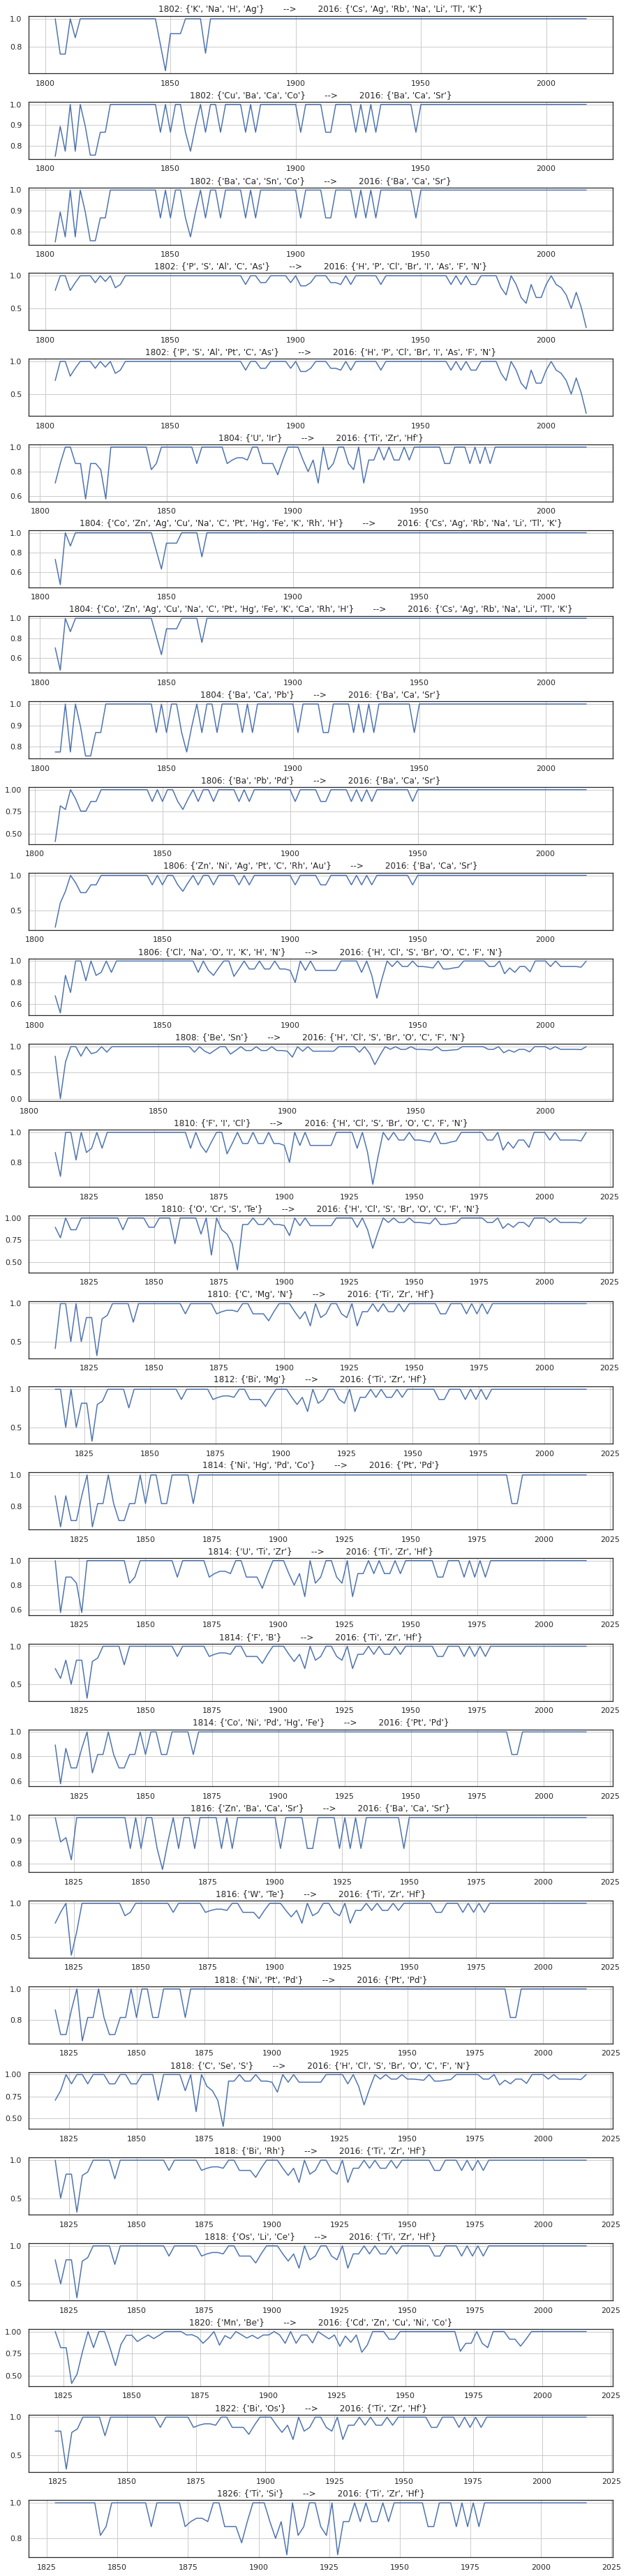

In [22]:
N=30
fig,ax = plt.subplots(N,1,figsize=(15,2*N+7),gridspec_kw={'hspace':0.5})
for i,(yr,gr,m2) in enumerate(grpsEvol[:N]):
    xs = np.arange(yr+2,2018,2)
    ax[i].plot(xs,m2[1:])
    ax[i].set_title(f"{yr}: {gr[0]}       -->        {2016}: {gr[-1]}")
    ax[i].grid()
    
plt.show()

### We now have a way of extracting groups from a similarity matrix, with a given ordering.

As we have 20 different orderings for every year, 20 different sets of groups will come up, so let's devise a way to "average out" the results, so that all different orderings are taken into account.

- The idea is sort of a voting mechanism. Groups are obtained by a consensus among all orderings.

In [85]:
yr=1868

# Get all groups obtained from each ordering
c = [getGroups_CV(yr,ind) for ind in range(20)]
c

[[{'Na'},
  {'K', 'Na'},
  {'Li', 'Na'},
  {'Cs', 'Rb'},
  {'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
  {'Ag', 'Cs', 'K', 'Li', 'Na', 'Rb', 'Tl'},
  {'Dy', 'Ho', 'Nd', 'Pr'},
  {'Si', 'Ti', 'Zr'},
  {'Si', 'Sn', 'Th', 'Ti', 'Zr'},
  {'Th', 'U'},
  {'Mo'},
  {'Mo', 'W'},
  {'Se'},
  {'S'},
  {'S', 'Se'},
  {'Cl'},
  {'Cl', 'H'},
  {'Br', 'C', 'Cl', 'H', 'N', 'O'},
  {'N'},
  {'Sb'},
  {'Bi', 'P', 'Sb'},
  {'B', 'Bi', 'Sb'},
  {'B', 'Nb'},
  {'B', 'Nb', 'Ta', 'V'},
  {'Ta', 'V'},
  {'Co', 'Fe'},
  {'Cr', 'Fe', 'Mn'},
  {'Al', 'Au', 'Co', 'Cr', 'Fe', 'In', 'Mn', 'Ni'},
  {'Rh'},
  {'Pb'},
  {'Sr'},
  {'Ba'},
  {'Ba', 'Ca', 'Sr'},
  {'Ba', 'Ca', 'Cd', 'Mg', 'Sr'},
  {'Zn'},
  {'Cu', 'Zn'},
  {'Ba', 'Ca', 'Cd', 'Cu', 'Hg', 'Mg', 'Pb', 'Sr', 'Zn'},
  {'Ba', 'Be', 'Ca', 'Cd', 'Cu', 'Hg', 'Mg', 'Pb', 'Pd', 'Sr', 'Zn'},
  {'Ir', 'Os', 'Pt'},
  {'Os'},
  {'Ce', 'Ir', 'Os', 'Pt'},
  {'Ag',
   'Al',
   'As',
   'Au',
   'B',
   'Ba',
   'Be',
   'Bi',
   'Br',
   'C',
   'Ca',
   'Cd',
   'Ce',
   'Cl',

### Voting mechanism:

- Each group obtained from each ordering will be regarded as a candidate. `Each ordering proposes a set of candidates`.

- Such candidates will be filtered out by comparison against all the other candidates of the other orderings. 

- Every group of every ordering gets a score from every other ordering.

- For each ordering, the groups with the higher mean score are selected.

### Score:

Suppose ordering `J` will score candidate `k`. Call this score S(J,k).

- The intersection `I` between `k` and each group `j` from `J` is calculated. 

- If len(`I`) is > 0, then the ratio between the length of `I`, and the length of `j` is calculated. 

- S(J,k) is calculated as the mean of such ratios.

In [81]:
results = {}

for order in range(20):
    for cand in c[order]:  # For each candidate in ordering 0
        total_scores = [0]
        for i in range(1,20):  # Each other ordering will score cand
            scores_i = []
            grps = c[i]
            for g in grps:
                I = cand.intersection(g)
                if len(I)>1: scores_i.append(len(I)/len(g))

            if len(scores_i)>0:
                total_scores.append(np.mean(scores_i))
                #print(f"{i:<4} {np.mean(scores_i):.3f} {str(cand):>5}")

        results[str(sorted(list(cand)))] = np.sum(total_scores)/19
        #print(f"{np.sum(total_scores)/19:.3f} {str(cand):10}")
    
pd.Series(results).sort_values(ascending=False).head(60)

['Ba', 'Ca', 'Cd', 'Cu', 'Mg', 'Ni', 'Sr', 'Zn']                                         0.908227
['Ce', 'Dy', 'Ho', 'Nd', 'Pr', 'Ta', 'Th']                                               0.887441
['Ce', 'Dy', 'Ho', 'Nd', 'Pr', 'Ru', 'Ta', 'Th']                                         0.887222
['As', 'Bi', 'Nb', 'P', 'Sb', 'Ta', 'V']                                                 0.886732
['Br', 'Cl', 'F', 'I', 'N', 'Nb', 'Ta', 'V']                                             0.886070
['Ag', 'Cs', 'K', 'Li', 'Na', 'Os', 'Pd', 'Pr', 'Pt', 'Rb', 'Tl']                        0.883566
['Al', 'As', 'B', 'Bi', 'Nb', 'P', 'Sb', 'U']                                            0.878404
['Ce', 'Dy', 'Ho', 'Nd', 'Pr', 'Ta']                                                     0.875146
['Ba', 'Ca', 'Cd', 'Cu', 'Mg', 'Sr', 'Zn']                                               0.870123
['Ba', 'Ca', 'Cd', 'Cu', 'Mg', 'Pb', 'Sr']                                               0.869079
['Ag', 'K', 'Li', 'N

---

### Automatically find groups of elements within the optimized orderings.

First, find all possible groups: Common groupings of elements between different lists on the same year. 

- Some flexibility is allowed: Elements need not be exactly in the same order OR even exactly contiguous.
    - In a similar manner to our similarity measure, we compare intersections between N-Grams, and store intersections having more than 1 element.

In [9]:
def findGroups_yr(yr,N=4):
    # Get all possible groups. Flexibility (N in Ngrams) has to be defined.
    cnt = {}
    map_set = {}

    pairs_indiv = product(Indivs_yr[yr],Indivs_yr[yr])
    for a,b in pairs_indiv:
        a,b = genToElem(a),genToElem(b)
        for i in range(103-N+1):
            ki = set(a[i:i+N])
            for j in range(103-N+1):
                inters = ki.intersection(b[j:j+N])
                if len(inters)>1:
                    in_str = str(sorted(list(inters)))
                    if not in_str in cnt: 
                        cnt[in_str] = 0
                        map_set[in_str] = inters

    # Count how many times each "group" appears on the orderings of a given year.
    for st in map_set.keys():
        for orderi in Indivs_yr[yr]:
            a = genToElem(orderi)
            for i in range(103-N+1):
                ki = set(a[i:i+N])
                if ki.intersection(map_set[st]) == map_set[st]:
                    cnt[st] += 1
                    break

    count = pd.Series(cnt).sort_values(ascending=False)
    return count, map_set

In [37]:
yr = 1868
cnt, map_set = findGroups_yr(yr,N=15)

In [44]:
for set_ in cnt.index:
    if len(map_set[set_])==3:
        print(f"{set_:30} {cnt[set_]}")

['Ba', 'Mn', 'Pb']             20
['Ag', 'K', 'Tl']              20
['Ag', 'Li', 'Na']             20
['Ca', 'Mn', 'Pb']             20
['Ag', 'Li', 'Tl']             20
['Ba', 'Mg', 'Pb']             20
['Ag', 'Na', 'Rb']             20
['Ag', 'Cs', 'Tl']             20
['Ag', 'K', 'Li']              20
['Ag', 'Rb', 'Tl']             20
['Li', 'Na', 'Rb']             20
['Cs', 'Na', 'Rb']             20
['Ca', 'Pb', 'Sr']             20
['Cs', 'Li', 'Rb']             20
['As', 'P', 'Sb']              20
['Ba', 'Ca', 'Mn']             20
['Ag', 'K', 'Na']              20
['Fe', 'Hg', 'Ni']             20
['Ba', 'Pb', 'Sr']             20
['Cs', 'Rb', 'Tl']             20
['K', 'Li', 'Na']              20
['Li', 'Rb', 'Tl']             20
['Bi', 'P', 'Sb']              20
['Cs', 'Li', 'Na']             20
['As', 'Bi', 'P']              20
['Co', 'Fe', 'Ni']             20
['Cs', 'K', 'Li']              20
['K', 'Rb', 'Tl']              20
['K', 'Na', 'Tl']              20
['Ba', 'Ca', '

['Fe', 'Sn', 'Zr']             9
['Ac', 'Am', 'At']             9
['Pa', 'Rn', 'Tc']             9
['Ag', 'Li', 'Pr']             9
['Lr', 'Md', 'Sc']             9
['Ra', 'Xe', 'Y']              9
['N', 'P', 'S']                9
['Ac', 'Pa', 'Pu']             9
['At', 'Md', 'Po']             9
['Cr', 'Os', 'Zr']             9
['C', 'N', 'Sb']               9
['Ir', 'Ru', 'U']              9
['Ar', 'He', 'Pa']             9
['No', 'Pu', 'Tb']             9
['Am', 'Rn', 'Sc']             9
['Cf', 'Eu', 'Pm']             9
['Ac', 'Gd', 'Y']              9
['Bi', 'Ir', 'Os']             9
['Co', 'Pd', 'Sn']             9
['C', 'O', 'Rb']               9
['Ge', 'He', 'Pu']             9
['Er', 'Lu', 'Md']             9
['Ar', 'Y', 'Yb']              9
['Cr', 'Th', 'U']              9
['Am', 'Rn', 'Yb']             9
['As', 'U', 'W']               9
['Cf', 'No', 'Y']              9
['Ac', 'Ne', 'Xe']             9
['Am', 'At', 'Sc']             9
['Er', 'Fm', 'Yb']             9
['Cm', 'Sm

['Cf', 'Er', 'Es']             6
['Bk', 'Fm', 'Ne']             6
['Eu', 'Hf', 'Lu']             6
['Es', 'Pm', 'Tc']             6
['Bk', 'Gd', 'Kr']             6
['Fm', 'Kr', 'Ra']             6
['Ac', 'Md', 'Ra']             6
['Be', 'Sr', 'U']              6
['Kr', 'Ne', 'Re']             6
['Am', 'Fm', 'Ga']             6
['Kr', 'Pm', 'Re']             6
['Ac', 'Bk', 'Pu']             6
['Lr', 'Re', 'Tb']             6
['Md', 'Po', 'Xe']             6
['Hg', 'Si', 'Ti']             6
['Lu', 'Tc', 'Tm']             6
['No', 'Pm', 'Po']             6
['Fm', 'Gd', 'Ne']             6
['O', 'Sn', 'Te']              6
['Pa', 'Tc', 'Y']              6
['Es', 'Hf', 'Tc']             6
['Al', 'Rh', 'Ti']             6
['Ne', 'Rn', 'Xe']             6
['Eu', 'Sc', 'Y']              6
['Ne', 'Np', 'Pm']             6
['Fm', 'Kr', 'Tb']             6
['Eu', 'Hf', 'Kr']             6
['Ar', 'Cf', 'Er']             6
['Bk', 'Ho', 'Pr']             6
['Md', 'No', 'Tc']             6
['Br', 'Ho

['Lr', 'Pm', 'Pu']             5
['Be', 'Ru', 'U']              5
['H', 'I', 'Pd']               5
['Cl', 'H', 'Pt']              5
['Eu', 'Fm', 'Np']             5
['Ga', 'Po', 'Re']             5
['Ga', 'Pm', 'Re']             5
['Fm', 'Kr', 'Tc']             5
['Es', 'Ne', 'Rn']             5
['Fm', 'Re', 'Tb']             5
['Be', 'Os', 'U']              5
['Lu', 'Pu', 'Ra']             5
['Dy', 'Th', 'Zr']             5
['Ne', 'Np', 'Rn']             5
['Ga', 'Tc', 'Tm']             5
['Lr', 'Pa', 'Xe']             5
['Ga', 'Ge', 'Tm']             5
['Fm', 'Kr', 'Re']             5
['Eu', 'Fm', 'Po']             5
['C', 'H', 'Zr']               5
['Md', 'Re', 'Xe']             5
['Ar', 'Cm', 'Tm']             5
['Eu', 'Lr', 'No']             5
['Cf', 'Po', 'Rn']             5
['As', 'P', 'Th']              5
['Na', 'Se', 'Te']             5
['K', 'Na', 'Te']              5
['Cm', 'Eu', 'Pu']             5
['Pa', 'Po', 'Xe']             5
['As', 'K', 'Tl']              5
['Ba', 'Se

['Os', 'P', 'S']               2
['Bk', 'Ne', 'Rn']             2
['C', 'Cr', 'Mn']              2
['Ho', 'Pr', 'Sc']             2
['Cm', 'Pr', 'Sc']             2
['Dy', 'Nd', 'Sc']             2
['Cm', 'Nd', 'Sc']             2
['Lr', 'Nd', 'Sc']             2
['Be', 'He', 'Np']             2
['Be', 'He', 'Tc']             2
['Pd', 'S', 'Zr']              2
['Ag', 'H', 'Zr']              2
['Cr', 'Cu', 'Mo']             2
['Cr', 'Nd', 'Os']             2
['Ac', 'He', 'Ho']             2
['Cs', 'He', 'Ho']             2
['Be', 'S', 'Se']              2
['Be', 'H', 'S']               2
['Os', 'Te', 'V']              2
['Cm', 'Re', 'Y']              2
['At', 'Md', 'Th']             2
['At', 'Th', 'W']              2
['Ac', 'Md', 'V']              2
['Ni', 'Rh', 'Sn']             2
['Be', 'Pt', 'Ru']             2
['Er', 'La', 'Rn']             2
['Er', 'La', 'Lu']             2
['La', 'Lu', 'Xe']             2
['Ga', 'La', 'Lu']             2
['Dy', 'Np', 'Th']             2
['Dy', 'Sn

In [43]:
for set_ in cnt.index:
    if 'Fe' in map_set[set_] and len(map_set[set_])==2:
        print(f"{set_:30} {cnt[set_]}")

['Fe', 'Hg']                   20
['Fe', 'Ni']                   20
['Co', 'Fe']                   20
['Ba', 'Fe']                   19
['Fe', 'Zn']                   19
['Ca', 'Fe']                   19
['Fe', 'Mg']                   19
['Fe', 'Sr']                   19
['Fe', 'Mn']                   19
['Cu', 'Fe']                   19
['Cd', 'Fe']                   18
['Fe', 'Pb']                   18
['Fe', 'Pt']                   17
['Fe', 'Pd']                   16
['Be', 'Fe']                   15
['Fe', 'Sn']                   14
['Fe', 'Si']                   10
['Fe', 'Mo']                   9
['Fe', 'U']                    9
['Fe', 'Te']                   9
['Fe', 'Ru']                   8
['Fe', 'Se']                   8
['Fe', 'Ir']                   8
['Fe', 'W']                    8
['C', 'Fe']                    8
['Cr', 'Fe']                   8
['As', 'Fe']                   7
['Bi', 'Fe']                   7
['Fe', 'Rh']                   6
['F', 'Fe']               

### Como una familia se parece a otros elementos? 


---

## Other side-results:

---

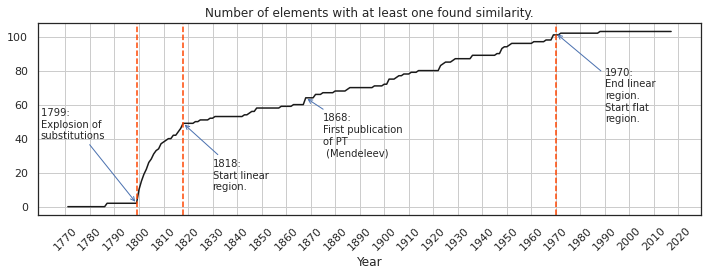

In [101]:
# Plot number of elements appearing in HND table each year
elem_count = (simMat_yr.sum(axis=1)>0).sum(axis=1)
plot_count_elems_w_matches(min_yr,2017,elem_count)

The interpretation of the numbers on y-axis is as follows: 

`An element Y is counted (for a given year), iff there exists at least one compound RXn, such that X = Y and at least one any other element. That is, if Y is related to any other element by a formula substitution relationship.`

This is an interesting plot, as it shows how relationships between elements, within the chemical space, evolve with time. It is quite interesting to see how compounds were mostly unrelated until 1800, but this year the number of related, or relatable elements, explodes and this explotion lasts until about 1818, where a seemingly constant growth is established.

Some questions arise, the most important being:

- What exactly happened in 1800? 
- Why are the numbers so low before this year?
- How can this linear regime be interpreted/explained?

Take into account that, to 1800, about 32 elements were known to humanity, [as shown here](https://environmentalchemistry.com/yogi/periodic/year.html). How come only 2 elements are related through a substitution relationship?.

### Let's explore the necessary conditions leading to the change we observe around 1800, which may help answer our first and second question.

To be simplistic, let's assume the number of related elements (F) is 0 before 1800, that is F(1799) = 0.
This means that, although some compounds are known, every one of these is a singular compound in terms of replaceability of elements. If we conceive each compound as the set of substitution formulas it gives rise to, then the set of compounds would be a non-overlapping partitioning of the space of substitution formulas, in this particular scenario.

With this in mind, whatever happened in 1800 can be abstracted as an introduction of a new set of compounds, one rich enough to build "bridges" between the aforementioned partitions. For the effects of this discussion, we may define "bridge" as follows.

- A new compound C -abstracted as a set of substitution formulas- is a $\textbf{bridge}$ between two other compounds A and B, if A $\cap$ B = $\varnothing$, while both C $\cap$ A and C $\cap$ B are not null.

This observation sets a $\textit{strict}$ lower bound for the possible generation of the periodic system: `No periodic system could have been created before 1800, even though 32 elements were known to that year.` There is, however, evidence that the PS could have been robustly postulated by the 1840s.

`If true, this would be a really interesting conclusion.` However, there is still the possibility that all of these results are influenced and biased by the way the data were curated, before and after I got my hands on it. 

---

### To answer our third question, let us explore a bit further the linear behaviour of this plot within the pertinent period.

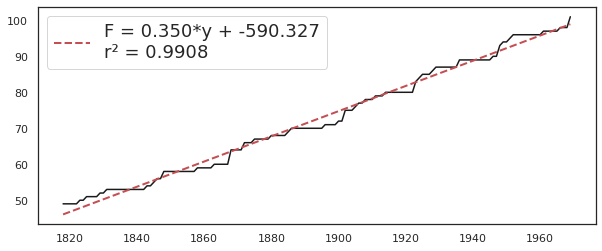

In [104]:
init = 1818
end = 1970

years = np.arange(init,end,1)
ec_subsamp = elem_count[init-min_yr:end-min_yr] # subsample of elem_count

# Fit linear model
from scipy.stats import linregress
lm = linregress(years,ec_subsamp) # Linear model
lin_pred = lm.slope*years + lm.intercept

fig, ax = plt.subplots(figsize=(10,4))
# Plot data
sns.lineplot(x=years,y=ec_subsamp,ax=ax,color='k')
# Plot linear model
label = f'F = {lm.slope:.3f}*y + {lm.intercept:.3f}\nr² = {lm.rvalue**2:.4f}'
sns.lineplot(x=years,y=lin_pred,ax=ax,color='r',
             label = label,linestyle='--',linewidth=2)
plt.legend(fontsize=18)
plt.show()

What we really care about here is the slope, which is about 0.35. This means that, very approximately, `about every three years, one element is brought into consideration for the construction of the Periodic System`, and for the results we just got, this has been a constant for nearly 152 years!.

Now, such a linear behaviour stopped after 1970, probably due to the fact that newer elements were produced synthetically and couldn't be produced in sufficient quantities to be able to form compounds, leaving nearly 16 of these elements out of consideration and as a consquence, stopping the linear increase we see.

---

# Calculate mean(HND) from SMs.

### To calculate a mean, we sum, and then divide by the number of elements.

# sum(HND):

Let's first calculate HND for a single element, H.

Each other element x contributes a given distance, a specific number of times. This distance D(H,X) is the difference in PT groups, which has to be counted N(H,X) times, N(H,X) being the number of times both H and X appear in the same table.

Thus, each element contributes a total N(H,X)*D(H,X) to the sum, which results in the sum:

<br>
<font color='red' >
    $$
    sum(HND(H)) = N(H,H)*D(H,H) + N(H,He)*D(H,He) + N(H,Li)*D(H,Li) + ...
    $$
</font>

Where a term for the pair (H,H) was added as $D(H,H) = 0$, by definition.

<br>
<font color='red' >
    $$
    \begin{align*}
    sum(HND(H)) &= \sum_{X} N(H,X)*D(H,X)\\
           &= \sum_{X} N(H,X)*D(X,H)
    \end{align*}
    $$
</font>

Due to the fact that both matrices are symetric.

---

#### Definitions:

1. Matrix D, where $D_{ij} = D(i,j)$ for elements i and j. 

2. Matrix N. $N_{ij} = N(i,j)$ for elements i and j. 

The above equation is realized as an inner product between the rows of D and N, correspondent to element H.

And, extending the argument to the complete set of elements, we compute the diagonal of the matrix product between N and D:

<br>
<font color='red' >
$$
sum(HND) = Diag(N*D)
$$
</font>

Which is a vector containing sum(HND(X)) for each element X.

# mean(HND):

Renamed as mHND for ease of write and read.

For that, we need to rescale Diag(N*D) using the total number of neighbors of each element.

Number of neighbors of H is equal to the sum of N(H), minus N(H,H); which generalizes as sum(N,axis=0) - Diag(N)

We end up with the following:

<br>
<font color='red' >
$$
mHND = \frac{Diag(N*D)}{sum(N,axis=0) - Diag(N) }
$$
</font>

# Calculation of D.

A vector `g` can be written, such that g(X) = group(X), representing the horizontal position of element X within a given PT (group). 

With this, we could repeat the vector to build a square matrix G, which then can be used to calculate D as follows:

<br>
<font color='red' >
$$
D = |G - G^T|
$$
</font>

Numpy broadcasting rules allow to do this without the repeating step being explicitly made. 

As such, we'd rather calculate 

<font color='red' >
$$
D = |g - g^T|
$$
</font>

The equation is then written in terms of the most fundamental variable here (g), as follows:

<br>
<font color='#8120b1' size=5 >
$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0) - Diag(N) }
$$
</font>

<br>
<font color='#3b8167' size=5 >
Note that N is already calculated and varies yearly, while D is a constant for a given PT, so this makes computation of mHND extremely efficient.
</font>


## Note: If we're looking forward to optimize mHND, that would be only an optimization with respect to element positions in PT, whose information is all encoded in matrix D.
<br>
<font color='green' size=5>
    Which might indicate that this problem can be solved mathematically! I don't yet know how though :c
</font>

<br>
<br>
<font color='red' size=4>
    Important: The original implementation of mHND didn't consider the term -Diag(N), so the results are reproduced if the following equation is used instead of the above.
</font>


$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0)}
$$

---

### Computational note:

Further efficiency can be achieved if the composition of operations `Diag(N*D)` is replaced in numpy with the single operation `np.einsum('ij,ji->i', N, D)`, which directly computes only the diagonal of the matrix product, instead of computing every element of such product, and then extracting the diagonal.

---

### In strict mathemathical terms, mHND for an element is calculated with the following expression:

$$
mHND_{i} = \frac{\sum_k N_{ik} | g_i - g_k |}{\sum_k N_{ik} - N_{ii}}
$$

### If sum of this quantity is used to score a PT, then we get the following:

$$
S = \sum_i \frac{\sum_k N_{ik} | g_i - g_k |}{\sum_k N_{ik} - N_{ii}}
$$

# Which is the quantity to be optimized


---


### Calculating gradients of S with respect to $g_i$ is now trivial.

$$
\frac{\partial S}{\partial g_j} = \sum_i \frac{ sign( g_i - g_j ) N_{ij} }{\sum_k N_{ik} - N_{ii}}
\\
As \\
\frac{\partial g_{k \neq j}}{\partial g_j} = 0
$$



In [52]:
# We regard this array as fixed, so don't count indexing in computation
N = simMat_yr[2015-min_yr]

In [53]:
%%timeit
g = np.array([TP[e][1] for e in elemList_AO]).reshape(1,-1)
D = np.abs(g - g.T)
hnd = np.einsum('ij,ji->i', N, D)/(N.sum(axis=0) - np.diag(N))

86.5 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [54]:
g = np.array([TP[e][1] for e in elemList_AO]).reshape(1,-1)
D = np.abs(g - g.T)
hnd = np.einsum('ij,ji->i', N, D)/(N.sum(axis=0) - np.diag(N))

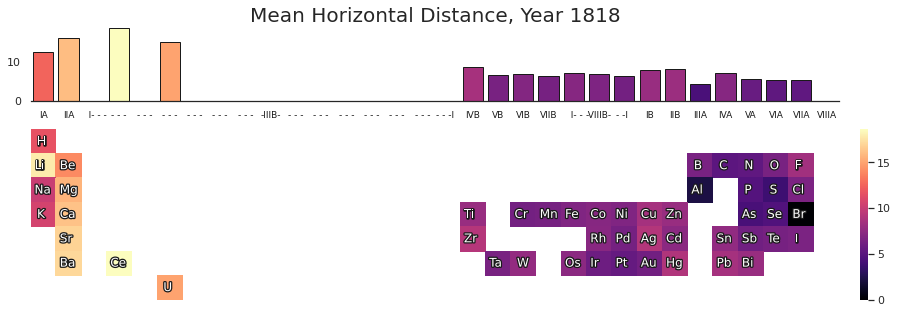

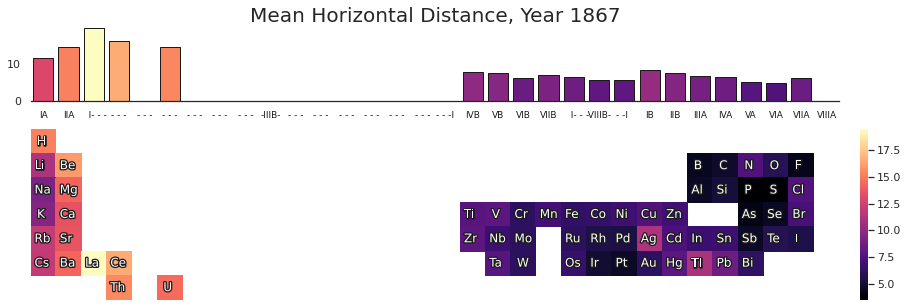

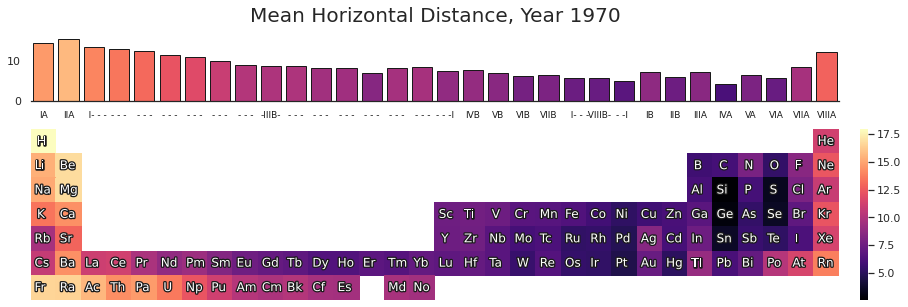

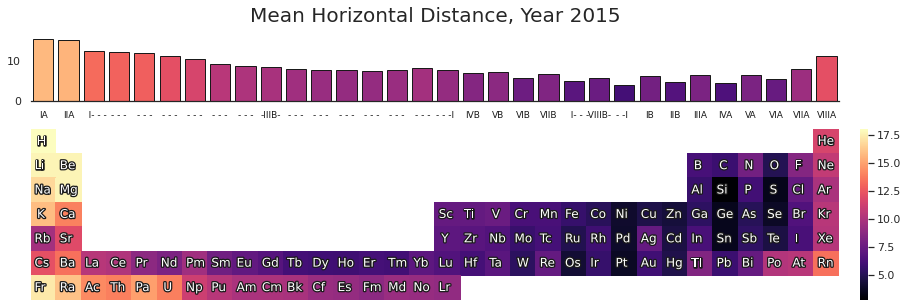

In [55]:
from HND import *

grid_kws = {'width_ratios': (0.99, 0.01), 
            'height_ratios':(0.3,0.7),
            'wspace': 0.05,'hspace':0.23}

dates = [1818,1867,1970,2015]

for d in dates:
    N = simMat_yr[d-min_yr]
    with np.errstate(invalid='ignore',divide='ignore'):
        hnd = np.diag(N@D)/(N.sum(axis=0))# - np.diag(N))
    
    dt = np.zeros((7,32))*np.nan
    for i,e in enumerate(elemList_AO):
        y,x = TP[e]
        dt[y,x] = hnd[i]

    min_scale = np.nanmin(dt)
    max_scale = np.nanmax(dt)

    fig, ax = plt.subplots(2, 2, gridspec_kw = grid_kws, figsize = (15, 5))

    makeTPPlot(dt,title=f"Mean Horizontal Distance, Year {d}",PT=TP,fs=10,ax=ax,
               min_scale=min_scale,max_scale=max_scale)
    plt.show()

# 1818-1867
We see that, for 1818, HND was overall high, with most elements showing an HND above 8, with no clear patterns throughout the table. Interestingly enough, as we move towards 1867, the values drop for most of the table, and now we start getting some patterns, such as lower HNDs to the right of the table.

This might indicate something about how rich was the chemical space at each time. For instance, these results may indicate that, by 1818, the CS wasn't rich enough so as to allow the production of the periodic system (at least the one we have now), while somewhere in between this year and 1868, the CS became rich enough to allow Mendeleev's formulation.

# 1867-1970
In general we observe an interesting evolution of some groups, and some "color gradients" horizontally. Particularly, we see that groups IVA and VIA somehow "survived" the evolution of the CS, and seem to be well preserved throughout history, which can be seen as the values of HND are low for most of these two groups, so we might expect these groups to have strong inner similarity relationships.

Furthermore, actninides and lanthanides show an pattern of decreasing HND when reading from left to right. This might be due to the fact that this group's elements show rather horizontal similarities.

# 1970-2017
Some more groups are further reinforced. Here we clearly see vertical patterns of low HNDs for groups IVA, VIA, as in 1970, showing that these groups further persevere throughout history, while other new ones such as Ni-Pd-Pt appear after nearly 50 years of evolution.

#### In general, we see that group IA and IIA elements show the higher HNDs, regardless of the moment in history, but this is particularly exhacerbated starting from 1970.

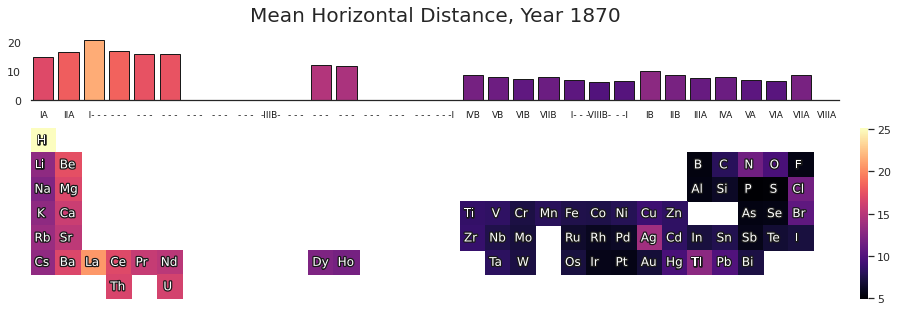

646.7829047956154


In [56]:
d = 1870

N = simMat_yr[d-min_yr]
with np.errstate(invalid='ignore',divide='ignore'):
    hnd = np.diag(N@D)/(N.sum(axis=0) - np.diag(N))

dt = np.zeros((7,32))*np.nan
for i,e in enumerate(elemList_AO):
    y,x = TP[e]
    dt[y,x] = hnd[i]

min_scale = np.nanmin(dt)
max_scale = np.nanmax(dt)

fig, ax = plt.subplots(2, 2, gridspec_kw = grid_kws, figsize = (15, 5))

makeTPPlot(dt,title=f"Mean Horizontal Distance, Year {d}",PT=TP,fs=10,ax=ax,
           min_scale=min_scale,max_scale=max_scale)
#,save='/home/andres/Schreibtisch/GR/work/inf/mHND_1868.png')
plt.show()

print(np.nansum(hnd))